<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
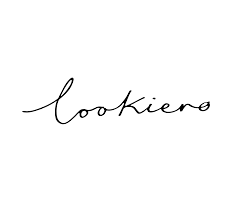    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Generación de grafos
Se genera el grafo que posteriormente se empleará para entrenar el modelo.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [2]:
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import when, regexp_replace, col, lit

- **Strings**

In [3]:
from collections import Counter
import re

- **Visualización**

In [4]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

* **Grafos**

In [5]:
import networkx as nx

- **Otros**

In [6]:
import itertools

## Clases a utilizar
---

In [7]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

class carga_datos:
    
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self):
        try: 
            path = os.getcwd()
            csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []
            for i in csv_files:
                temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
                dataframes_list.append(temp_df)
  
        except: pass
            
        return dataframes_list
    
    def subir_una_tabla(self, nombre_tabla):
        return spark.read.csv(dir_in + nombre_tabla + '.csv', header = True, inferSchema = True)
    
cd = carga_datos()

## Funciones a utilizar
---

In [8]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

* Función para **abrir y guardar pickles**

In [9]:
def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [10]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [11]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [12]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

* Función para añadir estilo y estampado al id

In [13]:
def listById(var):
    
    df_rdd = df.filter(df.id_product_feature.startswith(var))\
                    .select('id', 'value').distinct()\
                    .sort('value')\
                    .rdd.map(lambda x: (x.id, x.value))

    ids = df_rdd.reduceByKey(lambda x, y: x + '.' + y).toDF()\
                     .withColumnRenamed('_1', 'id_' + var)\
                     .withColumnRenamed('_2', var)
    return ids

* Función que crea el grafo filtrando por temporada

In [14]:
def create_graph(seasonality, pregancy):

    ##############
    ##### DF #####  
    ##############

    ### Filtrar por temporada ###
    df2 = df_fin.filter(df_fin.season == seasonality).filter(df_fin.pregnant == pregancy)

    ### Conseguir variantes de productos únicos#####
    vu_id_product = get_value(df2, 'id_variant')

    ### Crear df para filtrar ###
    df_para_filtrar = df_indices[df_indices[0].isin(vu_id_product)]
    df_para_filtrar['family_product'] = df_para_filtrar[0].str.split('_').str[0]
    df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)
    df_para_filtrar.columns = ['id_variant', 'family_product', 'level']

    df_para_filtrar.reset_index(inplace = True)
    df_para_filtrar['color'] = df_para_filtrar['id_variant'].str.split('_').str[1]
    df_para_filtrar = df_para_filtrar.merge(color_parent, left_on = 'color', right_on = 'name').drop('name', axis = 1)
    df_para_filtrar['color_id'] = df_para_filtrar.parent.map(color_number)
    df_para_filtrar.set_index('index', inplace = True)

    df_para_filtrar['style'] = df_para_filtrar.id_variant.str.split('_').str[4]
    df_para_filtrar['print'] = df_para_filtrar.id_variant.str.split('_').str[5]
    df_para_filtrar['premium'] = df_para_filtrar.id_variant.str.split('_').str[-1]

    ## Funciones auxiliares
    def sacar_productos(e, variable):

        if variable == 'style':

            list_1 = df_para_filtrar[df_para_filtrar[variable].map(lambda x: bool(True for i in x.split('.') if i == e[0]))].index.to_list()
            list_2 = df_para_filtrar[df_para_filtrar[variable].map(lambda x: bool(True for i in x.split('.') if i == e[1]))].index.to_list()

            return list(itertools.product(list_1, list_2))

        else:
            list_1 = df_para_filtrar[df_para_filtrar[variable] == e[0]].index.to_list()
            list_2 = df_para_filtrar[df_para_filtrar[variable] == e[1]].index.to_list()

            return list(itertools.product(list_1, list_2))

    def get_weight(e):
        
        d = tabla_style
        estilo = 0
        
        for uno in G.nodes[e[0]]['style'].split('.'):
            for dos in G.nodes[e[1]]['style'].split('.'):
                serie = d.loc[(d.node1 == uno) & (d.node2 == dos), 'weights']
                if len(serie) > 0:
                    num = float(serie)
                    if estilo < num: estilo = num

        suma = 0
        for var in tabla_pesos.keys():            
            d = tabla_pesos[var]
            suma += float(d.loc[(d.node1 == G.nodes[e[0]][var]) & (d.node2 == G.nodes[e[1]][var]), 'weights'])

        return tuple(list((e)) + [(estilo + suma) / 4])

    
    def ordenar(x): return tuple(sorted(x))
    
    #############
    ### NODOS ###
    #############

    vu_id_product = list(df_para_filtrar.id_variant.values) # Para que esten en el mismo orden
    G = nx.Graph()
    print('\nCreating nodes...\n')
    for i, v in enumerate(df_para_filtrar.index.tolist()):
            G.add_node(v,
                      color = vu_id_product[i].split('_')[1],
                      size  = vu_id_product[i].split('_')[2],
                      level = df_para_filtrar['level'][v],
                      color_parent = df_para_filtrar['parent'][v],
                      printed = df_para_filtrar['print'][v],
                      style = df_para_filtrar['style'][v],
                      premium = df_para_filtrar['premium'][v])

    ###############        
    ### ARISTAS ###
    ###############

    ### 1) Aristas - Tallas ###

    df_para_filtrar['talla'] = df_para_filtrar['id_variant'].str.split('_').str[2]
    orden_tallas = ['XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL','X4XL'] 
    
    combinaciones_tallas_letra = []
    for i in range(1, len(orden_tallas)): combinaciones_tallas_letra += [(orden_tallas[i - 1], orden_tallas[i])]
    for a in orden_tallas: combinaciones_tallas_letra += [(a, a), (a, 'UNQ')]
    combinaciones_talla = [sacar_productos(i, 'talla') for i in combinaciones_tallas_letra][1]

    for x in orden_tallas:
        list_1 = df_para_filtrar[df_para_filtrar['talla'] == x].index.to_list()
        combinaciones_talla += list(itertools.combinations(list_1, 2))

    
    combinaciones_talla = list(map(ordenar, combinaciones_talla))
    combinaciones_talla = list(set(combinaciones_talla))
    
    ### 2) Aristas - Level ###
    
    levels = get_value(df2.filter(df2.id_variant.isin(vu_id_product)), 'level')
    levels.sort()
    tods = list(itertools.combinations(levels, 2))
    tods.sort()
    tods += [('3.2', '3.2')]
    
    try: 
        tods.remove(('1.1', '1.2'))
    except: pass    
    
    
    combinaciones_level = list(map(sacar_productos, tods, ['level'] * len(tods)))
    combinaciones_level = list(itertools.chain(*combinaciones_level))
    combinaciones_level = list(map(ordenar, combinaciones_level))
    combinaciones_level = list(set(combinaciones_level))
    
    
    ### 3) Aristas - Style ###   

    print('Empieza style')
    unicos = ['classic', 'street', 'night', 'boho']
    comodin = ['casual', 'minimal']

    combinaciones_s = [('casual', 'minimal'), ('classic', 'night'), ('night', 'street'), ('boho', 'street')]
    for c in comodin:
        combinaciones_s += [(c, c)]
        for u in unicos:
            combinaciones_s += [(u, u)]
            combinaciones_s += [(c, u)]
            
    print('Empieza sacar productos')
    combinaciones_style = list(map(sacar_productos, combinaciones_s, ['style'] * len(combinaciones_s)))
    print('Termina sacar productos')
    combinaciones_style = list(itertools.chain(*combinaciones_style))
    print('Empieza ordernar')
    combinaciones_style = list(map(ordenar, combinaciones_style))
    print('Termina ordenar')
    combinaciones_style = list(set(combinaciones_style))
    
    ### 4) Aristas - Print ###
    combinaciones_p = [('smooth', 'smooth'), ('smooth', 'print')]
    combinaciones_print = list(map(sacar_productos, combinaciones_p, ['print'] * len(combinaciones_p)))
    combinaciones_print = list(itertools.chain(*combinaciones_print))
    combinaciones_print = list(map(ordenar, combinaciones_print))
    combinaciones_print = list(set(combinaciones_print))
    
    
    ### 5) Aristas - Color ###
    
    complementario = [(c, c + 6) for c in range(1, 7)]
    triangulo = []
    for t in [(c, c + 4, c + 8) for c in range(1, 5)]: triangulo += list(itertools.combinations(t, 2))
    teoria_colores = triangulo + complementario
    
    ## Eliminar los que no aparecen en esa temporada
    no_aparecen = list(set(range(1, 17)).difference(set(df_para_filtrar.color_id.unique())))
    teoria_colores_filt = []

    for t in teoria_colores:
        if len(set(t).difference(no_aparecen)) == 2:
            teoria_colores_filt += [t]
    
    ## Se relacionan todos con los colores base
    aparecen = df_para_filtrar.color_id.unique()

    base = aparecen[aparecen > 12]
    no_base = aparecen[aparecen <= 12]

    combinaciones_color = teoria_colores_filt
    for b in base:
        for no in no_base:
            combinaciones_color += [(b, no)]
            
    for a in aparecen: combinaciones_color += [(a, a)]
    combinaciones_color = list(map(sacar_productos, combinaciones_color, ['color_id'] * len(combinaciones_color)))   
    combinaciones_color = list(itertools.chain(*combinaciones_color))
    combinaciones_color = list(map(ordenar, combinaciones_color))
    combinaciones_color = list(set(combinaciones_color))
    
    
    ### Se añaden todas las aristas ###
    d = [combinaciones_level, combinaciones_talla, combinaciones_style, combinaciones_print, combinaciones_color]
    for e, n in zip(d, ['level', 'talla', 'style', 'print', 'color']): print(n, len(e))
    l = list(set.intersection(*map(set,d)))
    
    print(len(l))
    # l2 = [e for e in l if e[0] != e[1]] #por si acaso
    
    print('\nCreating edges...\n')
    # G.add_edges_from(l)
    G.add_weighted_edges_from(list(map(get_weight, l)))
    
    return G

### Cargar datos
---

In [15]:
df = spark.read.csv(dir_out + 'lookiero_*.csv', header = True, inferSchema = True)
df_total = spark.read.csv(dir_out + 'df_total.csv', header = True, inferSchema = True)

* Crear las variables necesarias para la creación del grafo

In [16]:
embarazadas = get_value(df.filter((df.value == "pregnancy") | (df.value == "breastfeeding")), 'id_product')
df = df.withColumn("level", col("level").cast(StringType()))
df = df.withColumn("pregnant", when(df.id_product.isin(embarazadas), 1).otherwise(0))

* Corregir el color para solucionar posibls posteriores errores

In [17]:
df = df.withColumn('color', regexp_replace('color', '_', ''))\
    .withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color'), lit('_'), f.col('size_lookiero'), lit('_'), f.col('season')))

* Añadir estilo, estampado y origin al *id*

In [18]:
id_style, id_print = list(map(listById, ['style', 'print']))

ids = id_style.join(id_print, id_print.id_print == id_style.id_style, 'full')\
        .drop('id_print').fillna('smooth', 'print')

* Adecuar variables

In [19]:
ids = ids.withColumn('print', when(ids.print != 'smooth', 'print').when(ids.print == 'smooth', 'smooth'))
df = df.withColumn('origin_brand', when(df.origin_brand == 'PREMIUM', 'PREMIUM').otherwise('NOPREMIUM'))

* Juntar los estilos y los estampadoscon el *df*

In [20]:
df_fin = ids.join(df, df.id == ids.id_style)\
        .withColumn('id_variant', f.concat(f.col('id_product'), lit('_'), f.col('style'), lit('_'), f.col('print'), lit('_'), f.col('origin_brand')))\
        .select('id_variant', 'pregnant', 'season', 'level')

df_fin = df_fin.filter(df_fin.id_variant.isNotNull()) # por si acaso
df_indices = pd.DataFrame(get_value(df_fin, 'id_variant'))

In [55]:
df_fin_2 = ids.join(df, df.id == ids.id_style)\
        .withColumn('id_variant', f.concat(f.col('id_product'), lit('_'), f.col('style'), lit('_'), f.col('print'), lit('_'), f.col('origin_brand')))\
        .select('id_variant', 'id_style', 'feature_family')

In [56]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        try: 
            path = os.getcwd()
            csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []
            for i in csv_files:
                temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
                dataframes_list.append(temp_df)
  
        except: pass
            
        return dataframes_list
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

cd = carga_datos ()
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

In [63]:
df_envios = dfs[2].join(df_fin_2, df_fin_2.id_style == dfs[2].id).select('id_variant', 'envios','ventas')
df_envios = df_envios.groupby('id_variant').agg(f.sum('envios').alias('envios'), f.sum('ventas').alias('ventas'))

In [67]:
df_envios = df_envios.toPandas()

In [69]:
guardar_pikle(df_envios, dir_out + 'df_envios')

### Grafo
---

* Reglas de unión grafos por **niveles**

In [21]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

* Reglas de unión de grafos por **colores**

In [22]:
color_names = ['red', 'red_orange', 'orange', 'yelloworange', 'yellow', 'yellowgreen', 
               'green', 'bluegreen', 'blue', 'blueviolet', 'violet', 'redviolet',
               'white', 'gray', 'black', 'brown']

red = ['800000', 'E65A5B', 'F29985', 'D84936', 'd0455f', '640b22', '8e1d03', 'B11730', 'FFC0CB']
red_orange = ['B94600', 'faaa6e']       #462C0E, A57E62, DFC8B2, C19A6B, 9A8176
orange = ['DEB24C', 'FFA500', 'B3832E', 'b3832e'] #EBD6A7
yellow_orange = ['FFD200', 'B5A45F']    #ECE9D6
yellow = ['666633', 'fdf7b2', 'FFFF00']
yellow_green = ['86BE2D']
green = ['BBE2AD', '164A0A', '008000', 'c4ddce']
blue_green = ['40E0D0', '87CEFA', '3B6968']
blue = ['00008b', '0000FF', '153668', '000081', '0053a5', 'bcd2e7']
blue_violet = ['BBA9E4']
violet = ['5C2F83'] 
red_violet = ['614051', 'FF00A8', 'fac4db']

white = ['FFFFFF']
gray = ['D3D3D3', '5F5E5E', 'C9C9C9', '808080', '768597', 'C7A2A2']
black = ['000000']
brown = ['A57E62', '462C0E', 'DFC8B2', 'C19A6B', '9A8176', 'ECE9D6', 'ebd6a7']


listas = [red, red_orange, orange, yellow_orange, yellow, yellow_green,
          green, blue_green, blue, blue_violet, violet, red_violet, 
          white, gray, black, brown]


colors = {}
for lista, name in zip(listas, color_names):
    for cod in lista:
        colors[cod] = name

color_number = {'red': 1,
                'redorange': 2,
                'orange': 3,
                'yelloworange': 4,
                'yellow': 5,
                'yellowgreen': 6,
                'green': 7,
                'bluegreen': 8,
                'blue': 9,
                'blueviolet': 10,
                'violet': 11,
                'redviolet': 12,
                'white': 13,
                'gray': 14,
                'black': 15,
                'brown': 16}

* Crear la relación color-parent

In [23]:
df_color = cd.subir_una_tabla('color')
df_dic_color = spark.createDataFrame(colors.items()).withColumnRenamed('_1', 'key').withColumnRenamed('_2', 'parent')
color_parent = df_color.select('hexadecimal', 'name')\
                       .join(df_dic_color, df_color.hexadecimal == df_dic_color.key)\
                       .drop('hexadecimal', 'key').toPandas()

color_parent['name'] = color_parent.name.str.replace('_', '')
color_parent['parent'] = color_parent.parent.str.replace('_', '')

---

* **Tablas de las ponderaciones**

1) Colores

In [24]:
complementario = [(c, c + 6) for c in range(1, 7)] + [(c + 6, c) for c in range(1, 7)]
triangulo = []
for t in [(c, c + 4, c + 8) for c in range(1, 5)]: triangulo += list(itertools.permutations(t, 2))
teoria_colores = triangulo + complementario

base = list(range(13, 17))
no_base = list(range(1, 13))
teoria_colores += [(no, no) for no in no_base + base]

for b in base:
    for no in no_base:
        teoria_colores += [(b, no), (no, b)]

teoria_colores += list(itertools.permutations(base, 2))

def bidireccional(o):
    return (o[1], o[0])

tabla_color = pd.DataFrame(teoria_colores)\
              .rename(columns = {0 : 'node1', 1 : 'node2'})
tabla_color = pd.concat([tabla_color, pd.Series([.5] * len(triangulo) + [.75] * len(complementario) + [.25] * 16 + [1] * 108)], axis = 1)\
                .rename(columns = {0 : 'weights'})

tabla_color['node1'] = tabla_color.node1.map({v:k for k, v in zip(color_number.keys(), color_number.values())})
tabla_color['node2'] = tabla_color.node2.map({v:k for k, v in zip(color_number.keys(), color_number.values())})

2) Style

In [25]:
unicos = ['classic', 'street', 'night', 'boho']
comodin = ['casual', 'minimal']

combinaciones_s = [('night', 'street'),  ('street', 'night'), 
                   ('boho', 'street'),   ('street', 'boho'), 
                   ('classic', 'night'), ('night', 'classic')]

for c in comodin:
    for u in unicos:
        combinaciones_s += [(c, u), (u, c)]

combinaciones_s += [('casual', 'minimal'), ('minimal', 'casual')]    

tabla_style = pd.DataFrame(combinaciones_s)\
              .rename(columns = {0 : 'node1', 1 : 'node2'})
tabla_style = pd.concat([tabla_style, pd.Series([.5] * 2 + [.25] * 4 + [1] * 18)], axis = 1)\
                .rename(columns = {0 : 'weights'})

3) Premium

In [26]:
tabla_premium = pd.DataFrame(itertools.product(('PREMIUM', 'NOPREMIUM'), repeat = 2))\
                .rename(columns = {0 : 'node1', 1 : 'node2'})
tabla_premium = pd.concat([tabla_premium, pd.Series([.25] * 2 + [.5] + [1])], axis = 1)\
                .rename(columns = {0 : 'weights'})

4) Estampados

In [27]:
tabla_estampados = pd.DataFrame(itertools.product(('smooth', 'print'), repeat = 2))\
                .rename(columns = {0 : 'node1', 1 : 'node2'})
tabla_estampados = pd.concat([tabla_estampados, pd.Series([1] * 3 + [0.15])], axis = 1)\
                .rename(columns = {0 : 'weights'})

Todos

In [28]:
tabla_pesos = {'color_parent': tabla_color, 'premium': tabla_premium, 'printed': tabla_estampados}

___

* Ponderaciones de relaciones

In [29]:
graph, combinaciones = [], list(itertools.product([7, 8, 9], [0]))

for x in combinaciones:
    
    print(f"\n=========== CREATING SEASON'S {x[0]} PREGNANCY GRAPH ===========", end = "\r")
    
    G = create_graph(x[0], x[1])
    graph.append(G)


=========== CREATING SEASON'S 7 PREGNANCY GRAPH ===========
Creating nodes...

Empieza style
Empieza sacar productos
Termina sacar productos
Empieza ordernar
Termina ordenar
level 6184654
talla 1638608
style 8957028
print 8036982
color 6581949
724721

Creating edges...


=========== CREATING SEASON'S 8 PREGNANCY GRAPH ===========
Creating nodes...

Empieza style
Empieza sacar productos
Termina sacar productos
Empieza ordernar
Termina ordenar
level 8436271
talla 2249428
style 11221953
print 10656437
color 8007356
1127449

Creating edges...


=========== CREATING SEASON'S 9 PREGNANCY GRAPH ===========
Creating nodes...

Empieza style
Empieza sacar productos
Termina sacar productos
Empieza ordernar
Termina ordenar
level 6658386
talla 1722412
style 9242850
print 8766074
color 6842450
858332

Creating edges...



* Asignar nombres

In [31]:
G7, G8, G9 = graph 
G7.name, G8.name, G9.name = 'G7', 'G8', 'G9'

* Nodos totales

In [34]:
len(np.unique(list(G8.nodes) + list(G9.nodes) + list(G7.nodes) ))

13268

* Plotear

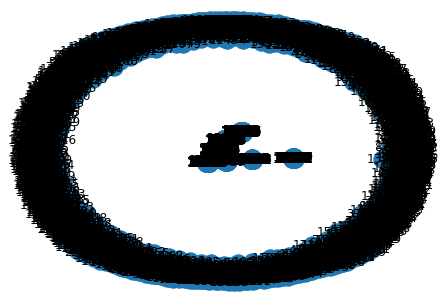

In [35]:
nx.draw(G7, with_labels = True)

* Guardar los grafos hasta ahora

In [34]:
guardar_pikle(G7, 'G7'), guardar_pikle(G8, 'G8'), guardar_pikle(G9, 'G9')

(None, None, None)

---